This file is for all intents and purposes a copy of the `basic_doom` scenario file, but with minor modifications to account for loading a different scenario config and different parameters such as availability of different and more game variables. We will also need to tune parameters, the `env` class, and a different reward structure. <br>

We will be tackling the Defend Center scenario in this file. Note: Doomguy will eventually die due to running out of ammo. Tragic.

In [1]:
# Imports 
from vizdoom import *  # Game env
import random  # Random action sampling
import time  # For sleeping+
import numpy as np  # Identity matrix and more

# We're going to need to define some shapes to get our frame data working with gym
# The way we do this is through Spaces
# The types we're going to use are Box and Discrete
# Box is an array of any shape
# Discrete is a set of discrete binary actions
from gym import Env  # OpenAI gym base class
from gym.spaces import Box, Discrete  # Spaces for gym
import cv2  # OpenCV for image processing
import matplotlib.pyplot as plt

%matplotlib inline

# Importing dependencies for training
import os  # For file nav
# Callback class for RL
from stable_baselines3.common.callbacks import BaseCallback
# We can use this to check our environment's format
from stable_baselines3.common import env_checker
# PPO for training
from stable_baselines3 import PPO
# Eval policy for testing models
from stable_baselines3.common.evaluation import evaluate_policy
# Monitor wrapper
from stable_baselines3.common.monitor import Monitor

In [2]:
# Create random actions
actions = np.identity(3, dtype=np.uint8)
actions

# Index 0 represents move left
# Index 1 represents move right
# Index 2 represents shoot

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

In [3]:
# Example of a Discrete space
Discrete(3).sample()  # Returns 0, 1 or 2
# We can use these for our action indices

1

In [4]:
# For example:
actions[Discrete(3).sample()]

array([0, 1, 0], dtype=uint8)

In [5]:
# Example of a Box space
Box(low=0, high=10, shape=(10, 10), dtype=np.uint8).sample()  # Returns a random array
# We will use this for our frame data
# In this case the shape would be passed as (640, 480) to fit the screen

array([[ 7,  9,  9,  1,  8,  4,  7,  3,  8,  1],
       [ 9, 10,  3,  1, 10,  1,  7,  8,  2,  2],
       [ 7,  9,  3,  9,  2,  2,  9,  3,  8,  1],
       [ 4,  7,  6,  9,  2,  4,  5,  9,  1,  9],
       [ 3,  9,  9,  0,  4,  4,  4,  1, 10,  5],
       [ 6, 10,  8, 10,  5,  6,  4,  7,  9,  0],
       [ 4,  0,  4, 10,  5,  7,  9, 10,  1,  0],
       [ 6, 10,  0,  2,  1,  6,  2,  4,  0,  6],
       [ 1,  0,  0,  0,  2,  7,  4,  3, 10,  2],
       [ 2,  5,  9,  8,  8,  6,  5,  1,  8, 10]], dtype=uint8)

In [2]:
# Create ViZDoom OpenAI Gym Environment
class VizDoomGym(Env):  # inherit from the Env base class
    # Initialization method
    def __init__(self, render=False):  # Render false lets us train faster
        # Inherit from env
        super().__init__()
        # Game setup
        self.game = DoomGame()
        # Different config loaded. Optionally you can turn it into a param for the class
        self.game.load_config("git_doom/ViZDoom/scenarios/defend_the_center.cfg")
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()  # Start the game after setting the params

        # Define the action and observation space
        self.observation_space = Box(low=0, high=255, 
            shape=(100, 160, 1), dtype=np.uint8)  # Resized shapes
        self.action_space = Discrete(3)  # Straightforward 

    # Perform an action/take a step in the environment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action], 4)  # 4 frames skipped

        # Get the other stuff we need to return, with error safety
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            # Currently the only game variable in use in the basic scenario
            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0  # Dummy descriptor
        
        info = {"info": info}
        done = self.game.is_episode_finished()

        return state, reward, done, info
    
    # Gray Scale and resize the game frame with cv2
    def grayscale(self, observation):  # Effectively passing our game frame
        # The image is the same we're just moving the colour channels to the last index
        # That's the format np expects
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)  # Make smaller
        state = np.reshape(resize, (100, 160, 1))  # Reshape to fit our space
        return state

    # Start a new game
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state) 

    # Close the environment/game
    def close(self):
        self.game.close()

    # Pre-Defined in VizDoom, staying pass for now
    # Usually where we define how to render the game or environment
    def render(self):
        pass

(100, 160, 1)
Observation space shape: (100, 160, 1)
Action space: 1
(array([[[10],
        [11],
        [ 6],
        ...,
        [10],
        [10],
        [ 6]],

       [[ 7],
        [10],
        [ 9],
        ...,
        [ 9],
        [11],
        [ 7]],

       [[ 5],
        [ 5],
        [ 7],
        ...,
        [ 3],
        [ 6],
        [ 7]],

       ...,

       [[50],
        [63],
        [56],
        ...,
        [47],
        [67],
        [52]],

       [[16],
        [36],
        [47],
        ...,
        [62],
        [61],
        [48]],

       [[22],
        [15],
        [31],
        ...,
        [64],
        [42],
        [45]]], dtype=uint8), 0.0, False, {'info': 26.0})
Environment is in correct format


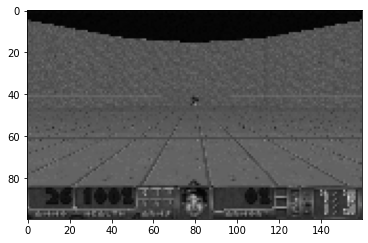

In [7]:
# Create environment
env = VizDoomGym(render=True)

# Testing
state = env.reset()
print(state.shape)

print(f'Observation space shape: {env.observation_space.sample().shape}')
print(f'Action space: {env.action_space.sample()}')

print(env.step(2))

plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

# Check if the environment is set up correctly with SB3's checker
env_checker.check_env(env)  # Will throw error if not
print("Environment is in correct format")

env.close()

In [3]:
# Standard Training and Logging Callback, refer to SB3 docs
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)

In [4]:
# Directory paths
CHECKPOINT_DIR_BASIC = './train/train_defend'
LOG_DIR_BASIC = './logs/log_defend'

In [5]:
callback = TrainAndLoggingCallback(check_freq=10000, 
    save_path=CHECKPOINT_DIR_BASIC)
# This saves the pytorch model's weights every 10000 steps

In [6]:
# The algorithm we're going to use to train our model is PPO
# The PPO implementation can be found in Stable Baselines 3
# Create a non rendered environment for training
train_env = VizDoomGym()
print("Creating training environment...")

# Create an instance of PPO
model = PPO(
    'CnnPolicy',  # Since we're using images
    train_env,  # Our environment for training
    tensorboard_log=LOG_DIR_BASIC,  # Where to save our logs
    verbose=1,  # Verbosity level
    learning_rate=0.0001,  # Learning rate
    n_steps=4096,  # Number of steps to train
)

Creating training environment...
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [12]:
# Training loop
model.learn(
    total_timesteps=100000,  # Number of steps to train
    callback=callback,  # Callback to save the model
)

Logging to ./logs/log_defend\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 76.7     |
|    ep_rew_mean     | 0.226    |
| time/              |          |
|    fps             | 77       |
|    iterations      | 1        |
|    time_elapsed    | 52       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 79.3        |
|    ep_rew_mean          | 0.24        |
| time/                   |             |
|    fps                  | 74          |
|    iterations           | 2           |
|    time_elapsed         | 109         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.003533938 |
|    clip_fraction        | 0.00303     |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 0.0505   

In [7]:
train_env.close()  # Cleanup

In [8]:
# Now we test the model, fully trained

# Load the model's most recent and best version
model = PPO.load("./train/train_defend/best_model_100000")  # Can also use model.load

# Test and evaluate model stats

# Creat a test environment
test_env = VizDoomGym(render=True)
# Wrap with SB3 Monitor class for error safety
test_env = Monitor(test_env, allow_early_resets=False)  # I don't want logs for this, you may set it to a log dir
# Evaluate mean reward for 100 games
print("Ripping and Tearing...")
mean_reward, _ = evaluate_policy(model, test_env, n_eval_episodes=10)
print("It is done")
print(f"Mean reward: {mean_reward}")
test_env.close()

Ripping and Tearing...
It is done
Mean reward: 12.2


In [10]:
# Use a loop to slow things down for visual clarity without evaluate_policy
test_env = VizDoomGym(render=True)
test_env = Monitor(test_env, allow_early_resets=False)

for episode in range(5):  # Play 5 games
    obs = test_env.reset()  # Store the current frame in observation
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)  # Get the action based on the observation
        obs, reward, done, info = test_env.step(action)  # Get info from step
        time.sleep(0.06)  # Have a small pause
        total_reward += reward  # Update the reward
    print(f"Episode {episode+1} reward: {total_reward}")
    time.sleep(2)  # Between each episode

test_env.close()

Episode 1 reward: 11.0
Episode 2 reward: 7.0
Episode 3 reward: 9.0
Episode 4 reward: 12.0
Episode 5 reward: 13.0
